# Projekt 1

Projekt przygotowali Mateusz Mulka i Mateusz Filas

In [16]:
import pandas as pd
import math
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.manifold import MDS
import scipy
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances

import warnings 
warnings.filterwarnings('ignore')

In [17]:
%%javascript
(function(on) {
const e=$( "<a>Setup failed</a>" );
const ns="js_jupyter_suppress_warnings";
var cssrules=$("#"+ns);
if(!cssrules.length) cssrules = $("<style id='"+ns+"' type='text/css'>div.output_stderr { } </style>").appendTo("head");
e.click(function() {
    var s='Showing';  
    cssrules.empty()
    if(on) {
        s='Hiding';
        cssrules.append("div.output_stderr, div[data-mime-type*='.stderr'] { display:none; }");
    }
    e.text(s+' warnings (click to toggle)');
    on=!on;
}).click();
$(element).append(e);
})(true);

<IPython.core.display.Javascript object>

# Opis danych


Na początku wczytujemy dane pochodzące ze strony kaggle.com, zawierające różne informacje o ponad 150 samochodach. Te informacje to:
- Marka
- Model
- Sprzedaż (w tyś.)
- Wartość samochodu po roku
- Typ
- Cena (w tyś.)
- Pojemność silnika
- Moc
- Rozstaw osi
- Szerokość
- Długość
- Ciężar własny
- Pojemność paliwa
- Wskaźnik oszczędności paliwa
- Ostatnie wydanie modelu
- Współczynnik wydajności mocy

Naszym celem w tym projekcie jest przeanalizowanie tych danych i utworzenie rankingu najlepszego samochodu na podstawie zmiennych objaśniających. W kolejnym etapie będziemy przeprowadzali analizę skupień, za której pomocą podzielimy samochody na grupy zależne od wartości poszczególnych zmiennych. Dzięki skalowaniu wielowymiarowego będziemy w stanie zmniejszyć ilość wymiarów opisujących samochody i zwizualizować je na wykresie 3D.

In [18]:
df = pd.read_csv('Car_sales.csv')

Teraz dokładniej przyjżyjmy się naszym zmiennym.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Manufacturer         157 non-null    object 
 1   Model                157 non-null    object 
 2   Sales_in_thousands   157 non-null    float64
 3   __year_resale_value  121 non-null    float64
 4   Vehicle_type         157 non-null    object 
 5   Price_in_thousands   155 non-null    float64
 6   Engine_size          156 non-null    float64
 7   Horsepower           156 non-null    float64
 8   Wheelbase            156 non-null    float64
 9   Width                156 non-null    float64
 10  Length               156 non-null    float64
 11  Curb_weight          155 non-null    float64
 12  Fuel_capacity        156 non-null    float64
 13  Fuel_efficiency      154 non-null    float64
 14  Latest_Launch        157 non-null    object 
 15  Power_perf_factor    155 non-null    flo

Warto zauważyć, że liczby wartości każdej z naszych zmiennych są do siebie w miarę podobne oraz, że w naszej ramce danych występują 4 zmienne, które nie są liczbami (z czego dwie, `Marka` i `Model` będą pełniły funkcję identyfikatora danego samochodu)

Tak przedstawia się 5 pierwszych wierszy naszej ramki danych.

In [20]:
df.head()

,Manufacturer,Model,Sales_in_thousands,__year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
0,Acura,Integra,16.919,16.360,Passenger,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2/2/2012,58.280150
1,Acura,TL,39.384,19.875,Passenger,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,6/3/2011,91.370778
2,Acura,CL,14.114,18.225,Passenger,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,1/4/2012,NaN
3,Acura,RL,8.588,29.725,Passenger,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,3/10/2011,91.389779
4,Audi,A4,20.397,22.255,Passenger,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,10/8/2011,62.777639


### Podstawowe statystyki 

In [21]:
df.describe(include='all')

,Manufacturer,Model,Sales_in_thousands,__year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
count,157,157,157.000000,121.000000,157,155.000000,156.000000,156.000000,156.000000,156.000000,156.000000,155.000000,156.000000,154.000000,157,155.000000
unique,30,156,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130,NaN
top,Dodge,Neon,NaN,NaN,Passenger,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10/5/2012,NaN
freq,11,2,NaN,NaN,116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
mean,NaN,NaN,52.998076,18.072975,NaN,27.390755,3.060897,185.948718,107.487179,71.150000,187.343590,3.378026,17.951923,23.844156,NaN,77.043591
std,NaN,NaN,68.029422,11.453384,NaN,14.351653,1.044653,56.700321,7.641303,3.451872,13.431754,0.630502,3.887921,4.282706,NaN,25.142664
min,NaN,NaN,0.110000,5.160000,NaN,9.235000,1.000000,55.000000,92.600000,62.600000,149.400000,1.895000,10.300000,15.000000,NaN,23.276272
25%,NaN,NaN,14.114000,11.260000,NaN,18.017500,2.300000,149.500000,103.000000,68.400000,177.575000,2.971000,15.800000,21.000000,NaN,60.407707
50%,NaN,NaN,29.450000,14.180000,NaN,22.799000,3.000000,177.500000,107.000000,70.550000,187.900000,3.342000,17.200000,24.000000,NaN,72.030917
75%,NaN,NaN,67.956000,19.875000,NaN,31.947500,3.575000,215.000000,112.200000,73.425000,196.125000,3.799500,19.575000,26.000000,NaN,89.414878


# Porządkowanie liniowe

Aby urzyć jednej z metod porządkowania liniowego należy zbadać czy zmienne nie są wzajemnie skorelowane.

In [22]:
corr_mat = df.corr()
corr_mat

,Sales_in_thousands,__year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
Sales_in_thousands,1.000000,-0.279034,-0.304734,0.019983,-0.197756,0.358179,0.140918,0.254980,0.008628,0.086540,-0.016764,-0.223252
__year_resale_value,-0.279034,1.000000,0.953840,0.531330,0.769081,-0.052270,0.178767,0.026548,0.361557,0.325567,-0.399880,0.827123
Price_in_thousands,-0.304734,0.953840,1.000000,0.626875,0.839744,0.110513,0.329136,0.156935,0.526224,0.423282,-0.492157,0.897945
Engine_size,0.019983,0.531330,0.626875,1.000000,0.837360,0.472130,0.690398,0.541424,0.760043,0.663022,-0.734622,0.818528
Horsepower,-0.197756,0.769081,0.839744,0.837360,1.000000,0.286308,0.539158,0.393364,0.610131,0.499907,-0.611332,0.992994
Wheelbase,0.358179,-0.052270,0.110513,0.472130,0.286308,1.000000,0.683135,0.839639,0.651016,0.654044,-0.497931,0.258852
Width,0.140918,0.178767,0.329136,0.690398,0.539158,0.683135,1.000000,0.710435,0.720927,0.656302,-0.602546,0.512025
Length,0.254980,0.026548,0.156935,0.541424,0.393364,0.839639,0.710435,1.000000,0.627163,0.563540,-0.446756,0.354095
Curb_weight,0.008628,0.361557,0.526224,0.760043,0.610131,0.651016,0.720927,0.627163,1.000000,0.863968,-0.818402,0.612071
Fuel_capacity,0.086540,0.325567,0.423282,0.663022,0.499907,0.654044,0.656302,0.563540,0.863968,1.000000,-0.801512,0.501184


Widać, że silna korelacja (przekraczająca $0,9$) występuje w parach:
-  `Cena` - `Wartość samochodu po roku`
- `Moc` - `Współczynnik wydajności mocy`

Wynika to z tego, ze te pary zmiennych przekazują praktycznie te same informacje.



Bardzo niską korelację można zaobserwować np w parach:
- `Sprzedaż` - `Ciężar własny`
- `Cena` - `Rozstaw osi`

co wynika z pratycznie zerowej zależności między tymi zmiennymi. 

Następnie trzeba zbadać zmienność, aby zmienne były dość różnorodne. Skorzystamy z klasycznego wspólczynnika zmienności. Zmienne, których wskaźnik będzie niższy od $ 0,1 $ zostaną odrzucone.

In [23]:
variability = df.std()/df.mean()
variability

Sales_in_thousands     1.283621
__year_resale_value    0.633730
Price_in_thousands     0.523960
Engine_size            0.341290
Horsepower             0.304925
Wheelbase              0.071090
Width                  0.048515
Length                 0.071696
Curb_weight            0.186648
Fuel_capacity          0.216574
Fuel_efficiency        0.179612
Power_perf_factor      0.326343
dtype: float64

W tym przypadku $3$ zmienne nie przekraczają wartości $0,1$. Te wartości to:
- `Rozstaw osi`
- `Długość`
- `Szerkość`

I jakby się zastanowić to faktycznie nie było to trudne do przewidzenia, ponieważ zmienne te dają informacje o wymiarach samochodu, a wszystkie samochody w tym zestawieniu to samochody osobowe.

Po zbadaniu korelacji oraz zmienności usunięte zostaną zmienne mówiące o:
- Ostatnim wydaniu modelu
- Typie samochodu
- Wartości samochodu po roku
- Długości
- Szerokości
- Rozstawie Osi
- Współczynniku wydajności mocy

In [24]:
df1 = df.drop(columns=['Width','Length','Wheelbase','Latest_Launch','Vehicle_type', '__year_resale_value', 'Power_perf_factor'])
print(df1)

    Manufacturer    Model  Sales_in_thousands  Price_in_thousands  \
0          Acura  Integra              16.919               21.50   
1          Acura       TL              39.384               28.40   
2          Acura       CL              14.114                 NaN   
3          Acura       RL               8.588               42.00   
4           Audi       A4              20.397               23.99   
..           ...      ...                 ...                 ...   
152        Volvo      V40               3.545               24.40   
153        Volvo      S70              15.245               27.50   
154        Volvo      V70              17.531               28.80   
155        Volvo      C70               3.493               45.50   
156        Volvo      S80              18.969               36.00   

     Engine_size  Horsepower  Curb_weight  Fuel_capacity  Fuel_efficiency  
0            1.8       140.0        2.639           13.2             28.0  
1            3.2   

W ramce danych danych można znaleźć:

Stymulanty: 
- Sales_in_thousands 
- Engine_size 
- Horsepower
- Fuel_capacity 
- Fuel_efficiency


Nominanty: 
- Price_in_thousands
- Curb_weight 

Przed operacjami na wartościach powinno się coś zrobić z brakującymi wartościami. Jedną z metod jest usunięcie wszystkich wartości `NaN`.

In [25]:
df2 = df1.dropna()
print(df2)

    Manufacturer    Model  Sales_in_thousands  Price_in_thousands  \
0          Acura  Integra              16.919               21.50   
1          Acura       TL              39.384               28.40   
3          Acura       RL               8.588               42.00   
4           Audi       A4              20.397               23.99   
5           Audi       A6              18.780               33.95   
..           ...      ...                 ...                 ...   
152        Volvo      V40               3.545               24.40   
153        Volvo      S70              15.245               27.50   
154        Volvo      V70              17.531               28.80   
155        Volvo      C70               3.493               45.50   
156        Volvo      S80              18.969               36.00   

     Engine_size  Horsepower  Curb_weight  Fuel_capacity  Fuel_efficiency  
0            1.8       140.0        2.639           13.2             28.0  
1            3.2   

Teraz przy pomocy dwóch metod porządkowania liniowego zostanie stworzony ranking najlepszych samochodów.

# Metoda Hellwiga 

### 1. Zamiana zmiennych na stymulanty.

Wśród zmiennych znajdują się dwie nominanty, które trzeba zamienić na stymulanty

In [26]:
price_mean = round(df2['Price_in_thousands'].mean(), 2)
weight_mean = round(df2['Curb_weight'].mean(), 2)

df2.loc[df2["Price_in_thousands"] > price_mean, "Price"] = 1/(df2["Price_in_thousands"] - price_mean + 1)
df2.loc[df2["Price_in_thousands"] < price_mean, "Price"] = -1/(df2["Price_in_thousands"] - price_mean - 1)
df2.loc[df2["Curb_weight"] > weight_mean, "weight"] = 1/(df2["Curb_weight"] - weight_mean + 1)
df2.loc[df2["Curb_weight"] < weight_mean, "weight"] = -1/(df2["Curb_weight"] - weight_mean - 1)
df2.head()


,Manufacturer,Model,Sales_in_thousands,Price_in_thousands,Engine_size,Horsepower,Curb_weight,Fuel_capacity,Fuel_efficiency,Price,weight
0,Acura,Integra,16.919,21.50,1.8,140.0,2.639,13.2,28.0,0.146413,0.574383
1,Acura,TL,39.384,28.40,3.2,225.0,3.517,17.2,25.0,0.483092,0.879507
3,Acura,RL,8.588,42.00,3.5,210.0,3.850,18.0,22.0,0.063816,0.680272
4,Audi,A4,20.397,23.99,1.8,150.0,2.998,16.4,27.0,0.230415,0.723589
5,Audi,A6,18.780,33.95,2.8,200.0,3.561,18.5,22.0,0.131234,0.846740


Zmienne `Price` oraz `Weight`, będące już stymulantami, zastępują w tym momencie zmienne `Price_in_thousands` oraz `Curb_weight`.

In [27]:
df3 = df2.drop(columns=['Price_in_thousands', 'Curb_weight'])
df3.head()

,Manufacturer,Model,Sales_in_thousands,Engine_size,Horsepower,Fuel_capacity,Fuel_efficiency,Price,weight
0,Acura,Integra,16.919,1.8,140.0,13.2,28.0,0.146413,0.574383
1,Acura,TL,39.384,3.2,225.0,17.2,25.0,0.483092,0.879507
3,Acura,RL,8.588,3.5,210.0,18.0,22.0,0.063816,0.680272
4,Audi,A4,20.397,1.8,150.0,16.4,27.0,0.230415,0.723589
5,Audi,A6,18.780,2.8,200.0,18.5,22.0,0.131234,0.846740


### 2. Standaryzacja danych.

Należy wykorzystać wzór:
 
 $ z_{ij} =  \frac{x_{ij} - \bar{x_{j}}}{s_{x_{j}}}$




In [28]:
normalized_df = round((df3-df3.mean())/df3.std(), 2)


In [29]:
normalized_df['Model'] = df3['Model']
normalized_df['Manufacturer'] = df3['Manufacturer']
titles = ['Manufacturer', 'Model', 'Sales_in_thousands', 'Engine_size', 'Horsepower', 'Fuel_capacity', 'Fuel_efficiency', 'Price', 'weight']
normalized_df = normalized_df.reindex(columns=titles)
normalized_df.head()

,Manufacturer,Model,Sales_in_thousands,Engine_size,Horsepower,Fuel_capacity,Fuel_efficiency,Price,weight
0,Acura,Integra,-0.53,-1.19,-0.79,-1.21,0.97,-0.12,-0.85
1,Acura,TL,-0.20,0.14,0.71,-0.19,0.27,1.92,1.07
3,Acura,RL,-0.65,0.43,0.44,0.01,-0.43,-0.63,-0.19
4,Audi,A4,-0.48,-1.19,-0.61,-0.40,0.73,0.38,0.09
5,Audi,A6,-0.50,-0.24,0.27,0.14,-0.43,-0.22,0.86


### 3. Utworzenie wzorca ("najlepszego" obiektu).

Tak prezentuje się wektor z "najlepszymi" wartościami poszczególnych zmiennych - "najlepszy" obiekt.

In [30]:
pattern = {
    "Sprzedaż": normalized_df['Sales_in_thousands'].max(),
    "Silnik": normalized_df['Engine_size'].max(),
    "Moc": normalized_df['Horsepower'].max(),
    "Pojemność paliwa": normalized_df['Fuel_capacity'].max(),
    "Wydajność paliwa": normalized_df['Fuel_efficiency'].max(),
    "Cena": normalized_df['Price'].max(),
    "Szerokość": normalized_df['weight'].max()
}
print(pattern)

{'Sprzedaż': 7.07, 'Silnik': 4.72, 'Moc': 4.67, 'Pojemność paliwa': 3.57, 'Wydajność paliwa': 4.91, 'Cena': 4.17, 'Szerokość': 1.82}


### 4. Obliczanie odległości poszczególnych obiektów od wzorca.

Wykorzystana zostaje wersja bez uwzględniania wag.


In [31]:
distance = normalized_df.iloc[:, 2:9]
distance = (distance - distance.max())**2
distance['Distance'] = distance.sum(axis=1)**(1/2)

df4 = round(distance, 2)
df4['Manufacturer'] = normalized_df['Manufacturer']
df4['Model'] = normalized_df['Model']
df4.head()

,Sales_in_thousands,Engine_size,Horsepower,Fuel_capacity,Fuel_efficiency,Price,weight,Distance,Manufacturer,Model
0,57.76,34.93,29.81,22.85,15.52,18.40,7.13,13.65,Acura,Integra
1,52.85,20.98,15.68,14.14,21.53,5.06,0.56,11.44,Acura,TL
3,59.60,18.40,17.89,12.67,28.52,23.04,4.04,12.81,Acura,RL
4,57.00,34.93,27.88,15.76,17.47,14.36,2.99,13.05,Audi,A4
5,57.30,24.60,19.36,11.76,28.52,19.27,0.92,12.72,Audi,A6


### 5. Stworzenie odległości "możliwie dalekiej".

In [72]:
maxDistance = distance['Distance'].mean() + 2 * distance['Distance'].std()
print(maxDistance)
distance.head()

14.23376134111529


,Sales_in_thousands,Engine_size,Horsepower,Fuel_capacity,Fuel_efficiency,Price,weight,Distance
0,57.7600,34.9281,29.8116,22.8484,15.5236,18.4041,7.1289,13.653011
1,52.8529,20.9764,15.6816,14.1376,21.5296,5.0625,0.5625,11.436918
3,59.5984,18.4041,17.8929,12.6736,28.5156,23.0400,4.0401,12.812677
4,57.0025,34.9281,27.8784,15.7609,17.4724,14.3641,2.9929,13.053708
5,57.3049,24.6016,19.3600,11.7649,28.5156,19.2721,0.9216,12.717732


### 6. Wyznaczenie wartości miary dla każdego obiektu.

In [33]:
measureValue = normalized_df.iloc[:, 1:2]
measureValue['Hellwig'] = 1 - distance['Distance']/maxDistance
df5 = pd.DataFrame
df5 = pd.concat([measureValue['Hellwig'], normalized_df['Manufacturer'], normalized_df['Model']], axis=1, join="inner")
df5

,Hellwig,Manufacturer,Model
0,0.040801,Acura,Integra
1,0.196494,Acura,TL
3,0.099839,Acura,RL
4,0.082905,Audi,A4
5,0.106509,Audi,A6
...,...,...,...
152,0.071132,Volvo,V40
153,0.149570,Volvo,S70
154,0.130578,Volvo,V70
155,0.091412,Volvo,C70


### 7. Posortowanie obiektów względem wartości uzyskanych w kroku $6$.

In [73]:

final_df = df5.sort_values(by=['Hellwig'], ascending = False)
pd.set_option('display.max_rows', df.shape[0]+1)
final_df

,Hellwig,Manufacturer,Model
56,0.377597,Ford,F-Series
52,0.255109,Ford,Explorer
69,0.243723,Jeep,Grand Cherokee
13,0.241247,Buick,LeSabre
40,0.235513,Dodge,Ram Pickup
103,0.222868,Nissan,Maxima
44,0.221339,Dodge,Durango
138,0.202703,Toyota,Avalon
49,0.200652,Ford,Taurus
24,0.200389,Chevrolet,Corvette


Powyżej można zobaczyć, że w powstałym rankingu z dość dużą przewagą wygrywa Ford serii F, a zdecydowanym przegranym jest Chevrolet Metro. Wartości wahają się od około $-0,037$ do $0,378$.

# Metoda standaryzowanych sum

Pierwsze dwa etapy pokrywają się z tymi z metody Hellwiga, zatem od razu można przejść do punktu $3$.

### 3. Budowa syntetycznej miary

Wykorzystana zostanie wersja bez uwzględniania wag.

In [35]:
distance1 = normalized_df.iloc[:, 2:9]
distance1['Distance'] = distance1.sum(axis=1)/distance1.count(axis=1)

distance1['Manufacturer'] = normalized_df['Manufacturer']
distance1['Model'] = normalized_df['Model']
distance1.head()

,Sales_in_thousands,Engine_size,Horsepower,Fuel_capacity,Fuel_efficiency,Price,weight,Distance,Manufacturer,Model
0,-0.53,-1.19,-0.79,-1.21,0.97,-0.12,-0.85,-0.531429,Acura,Integra
1,-0.20,0.14,0.71,-0.19,0.27,1.92,1.07,0.531429,Acura,TL
3,-0.65,0.43,0.44,0.01,-0.43,-0.63,-0.19,-0.145714,Acura,RL
4,-0.48,-1.19,-0.61,-0.40,0.73,0.38,0.09,-0.211429,Audi,A4
5,-0.50,-0.24,0.27,0.14,-0.43,-0.22,0.86,-0.017143,Audi,A6


### 4. Standaryzacja wartości uzyskanych w poprzednim kroku.

In [74]:
df6 = distance1
df6['sDistance'] = (distance1['Distance'] - distance1['Distance'].min()) / (distance1['Distance'] - distance1['Distance'].min()).max()
df6.head()

,Sales_in_thousands,Engine_size,Horsepower,Fuel_capacity,Fuel_efficiency,Price,weight,Distance,Manufacturer,Model,sDistance
0,-0.53,-1.19,-0.79,-1.21,0.97,-0.12,-0.85,-0.531429,Acura,Integra,0.096812
1,-0.20,0.14,0.71,-0.19,0.27,1.92,1.07,0.531429,Acura,TL,0.528116
3,-0.65,0.43,0.44,0.01,-0.43,-0.63,-0.19,-0.145714,Acura,RL,0.253333
4,-0.48,-1.19,-0.61,-0.40,0.73,0.38,0.09,-0.211429,Audi,A4,0.226667
5,-0.50,-0.24,0.27,0.14,-0.43,-0.22,0.86,-0.017143,Audi,A6,0.305507


### 5. Posortowanie obiektów względem wartości uzyskanych w poprzednim kroku.

In [37]:
final_df2 = df6[['Manufacturer', 'Model', 'sDistance']]
final_df2 = final_df2.sort_values(by=['sDistance'], ascending=False)
final_df2

,Manufacturer,Model,sDistance
56,Ford,F-Series,1.000000
39,Dodge,Viper,0.776232
13,Buick,LeSabre,0.618551
69,Jeep,Grand Cherokee,0.605797
24,Chevrolet,Corvette,0.596522
103,Nissan,Maxima,0.580290
44,Dodge,Durango,0.567536
52,Ford,Explorer,0.547246
90,Mercury,Mountaineer,0.547246
40,Dodge,Ram Pickup,0.546087


Warto zauważyć, że otrzymane wyniki są do siebie dość podobne. W przypadku obu metod, w rankingu najlepiej wypada Ford serii F. Wysoko znajdują się również samochody takie jak Jeep Grand Cherokee, czy Buick LeSabre. Dzieje się tak ze względu na to, że wszystkie stymulanty opisujące te samochody przyjmują wysokie wartości, a nominanty mają wartość zbliżoną do tej idealnej. Jeśli chodzi o dolną część rankingu, tam najgorzej wypadają Hyundai Accent, Chevrolet Metro, czy Saturn SW.
Porównując wyniki uzyskane za pomocą tych dwóch metod, ciężko znaleźć jakieś większe różnice w pozycjach zajmowanych przez poszczególne samochody.

# Analiza skupień

In [75]:
df_3 = df.drop(columns=['Width','Length','Wheelbase','Latest_Launch','Vehicle_type','__year_resale_value'])
df_3 = df_3.fillna(df_3.mean())
df_3.head()

,Manufacturer,Model,Sales_in_thousands,Price_in_thousands,Engine_size,Horsepower,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
0,Acura,Integra,16.919,21.500000,1.8,140.0,2.639,13.2,28.0,58.280150
1,Acura,TL,39.384,28.400000,3.2,225.0,3.517,17.2,25.0,91.370778
2,Acura,CL,14.114,27.390755,3.2,225.0,3.470,17.2,26.0,77.043591
3,Acura,RL,8.588,42.000000,3.5,210.0,3.850,18.0,22.0,91.389779
4,Audi,A4,20.397,23.990000,1.8,150.0,2.998,16.4,27.0,62.777639


Przygotowujemy dane liczbowe do standaryzacji

In [78]:
df_4 = df_3.set_index(['Manufacturer','Model'])
df_4.info()
df_4.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 157 entries, ('Acura', 'Integra') to ('Volvo', 'S80')
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sales_in_thousands  157 non-null    float64
 1   Price_in_thousands  157 non-null    float64
 2   Engine_size         157 non-null    float64
 3   Horsepower          157 non-null    float64
 4   Curb_weight         157 non-null    float64
 5   Fuel_capacity       157 non-null    float64
 6   Fuel_efficiency     157 non-null    float64
 7   Power_perf_factor   157 non-null    float64
dtypes: float64(8)
memory usage: 17.0+ KB


Sales_in_thousands  Price_in_thousands  Engine_size  \
Manufacturer Model                                                          
Acura        Integra              16.919           21.500000          1.8   
             TL                   39.384           28.400000          3.2   
             CL                   14.114           27.390755          3.2   
             RL                    8.588           42.000000          3.5   
Audi         A4                   20.397           23.990000          1.8   

                      Horsepower  Curb_weight  Fuel_capacity  Fuel_efficiency  \
Manufacturer Model                                                              
Acura        Integra       140.0        2.639           13.2             28.0   
             TL            225.0        3.517           17.2             25.0   
             CL            225.0        3.470           17.2             26.0   
             RL            210.0        3.850           18.0             22.0   
Audi         A4            150.0        2.998           16.4             27.0   

                      Power_perf_factor  
Manufacturer Model                       
Acura        Integra          58.280150  
             TL               91.370778  
             CL               77.043591  
             RL               91.389779  
Audi         A4               62.777639

### Grupowanie podziałowe

W pierwszym kroku chcemy zweryfikować podział na grupy

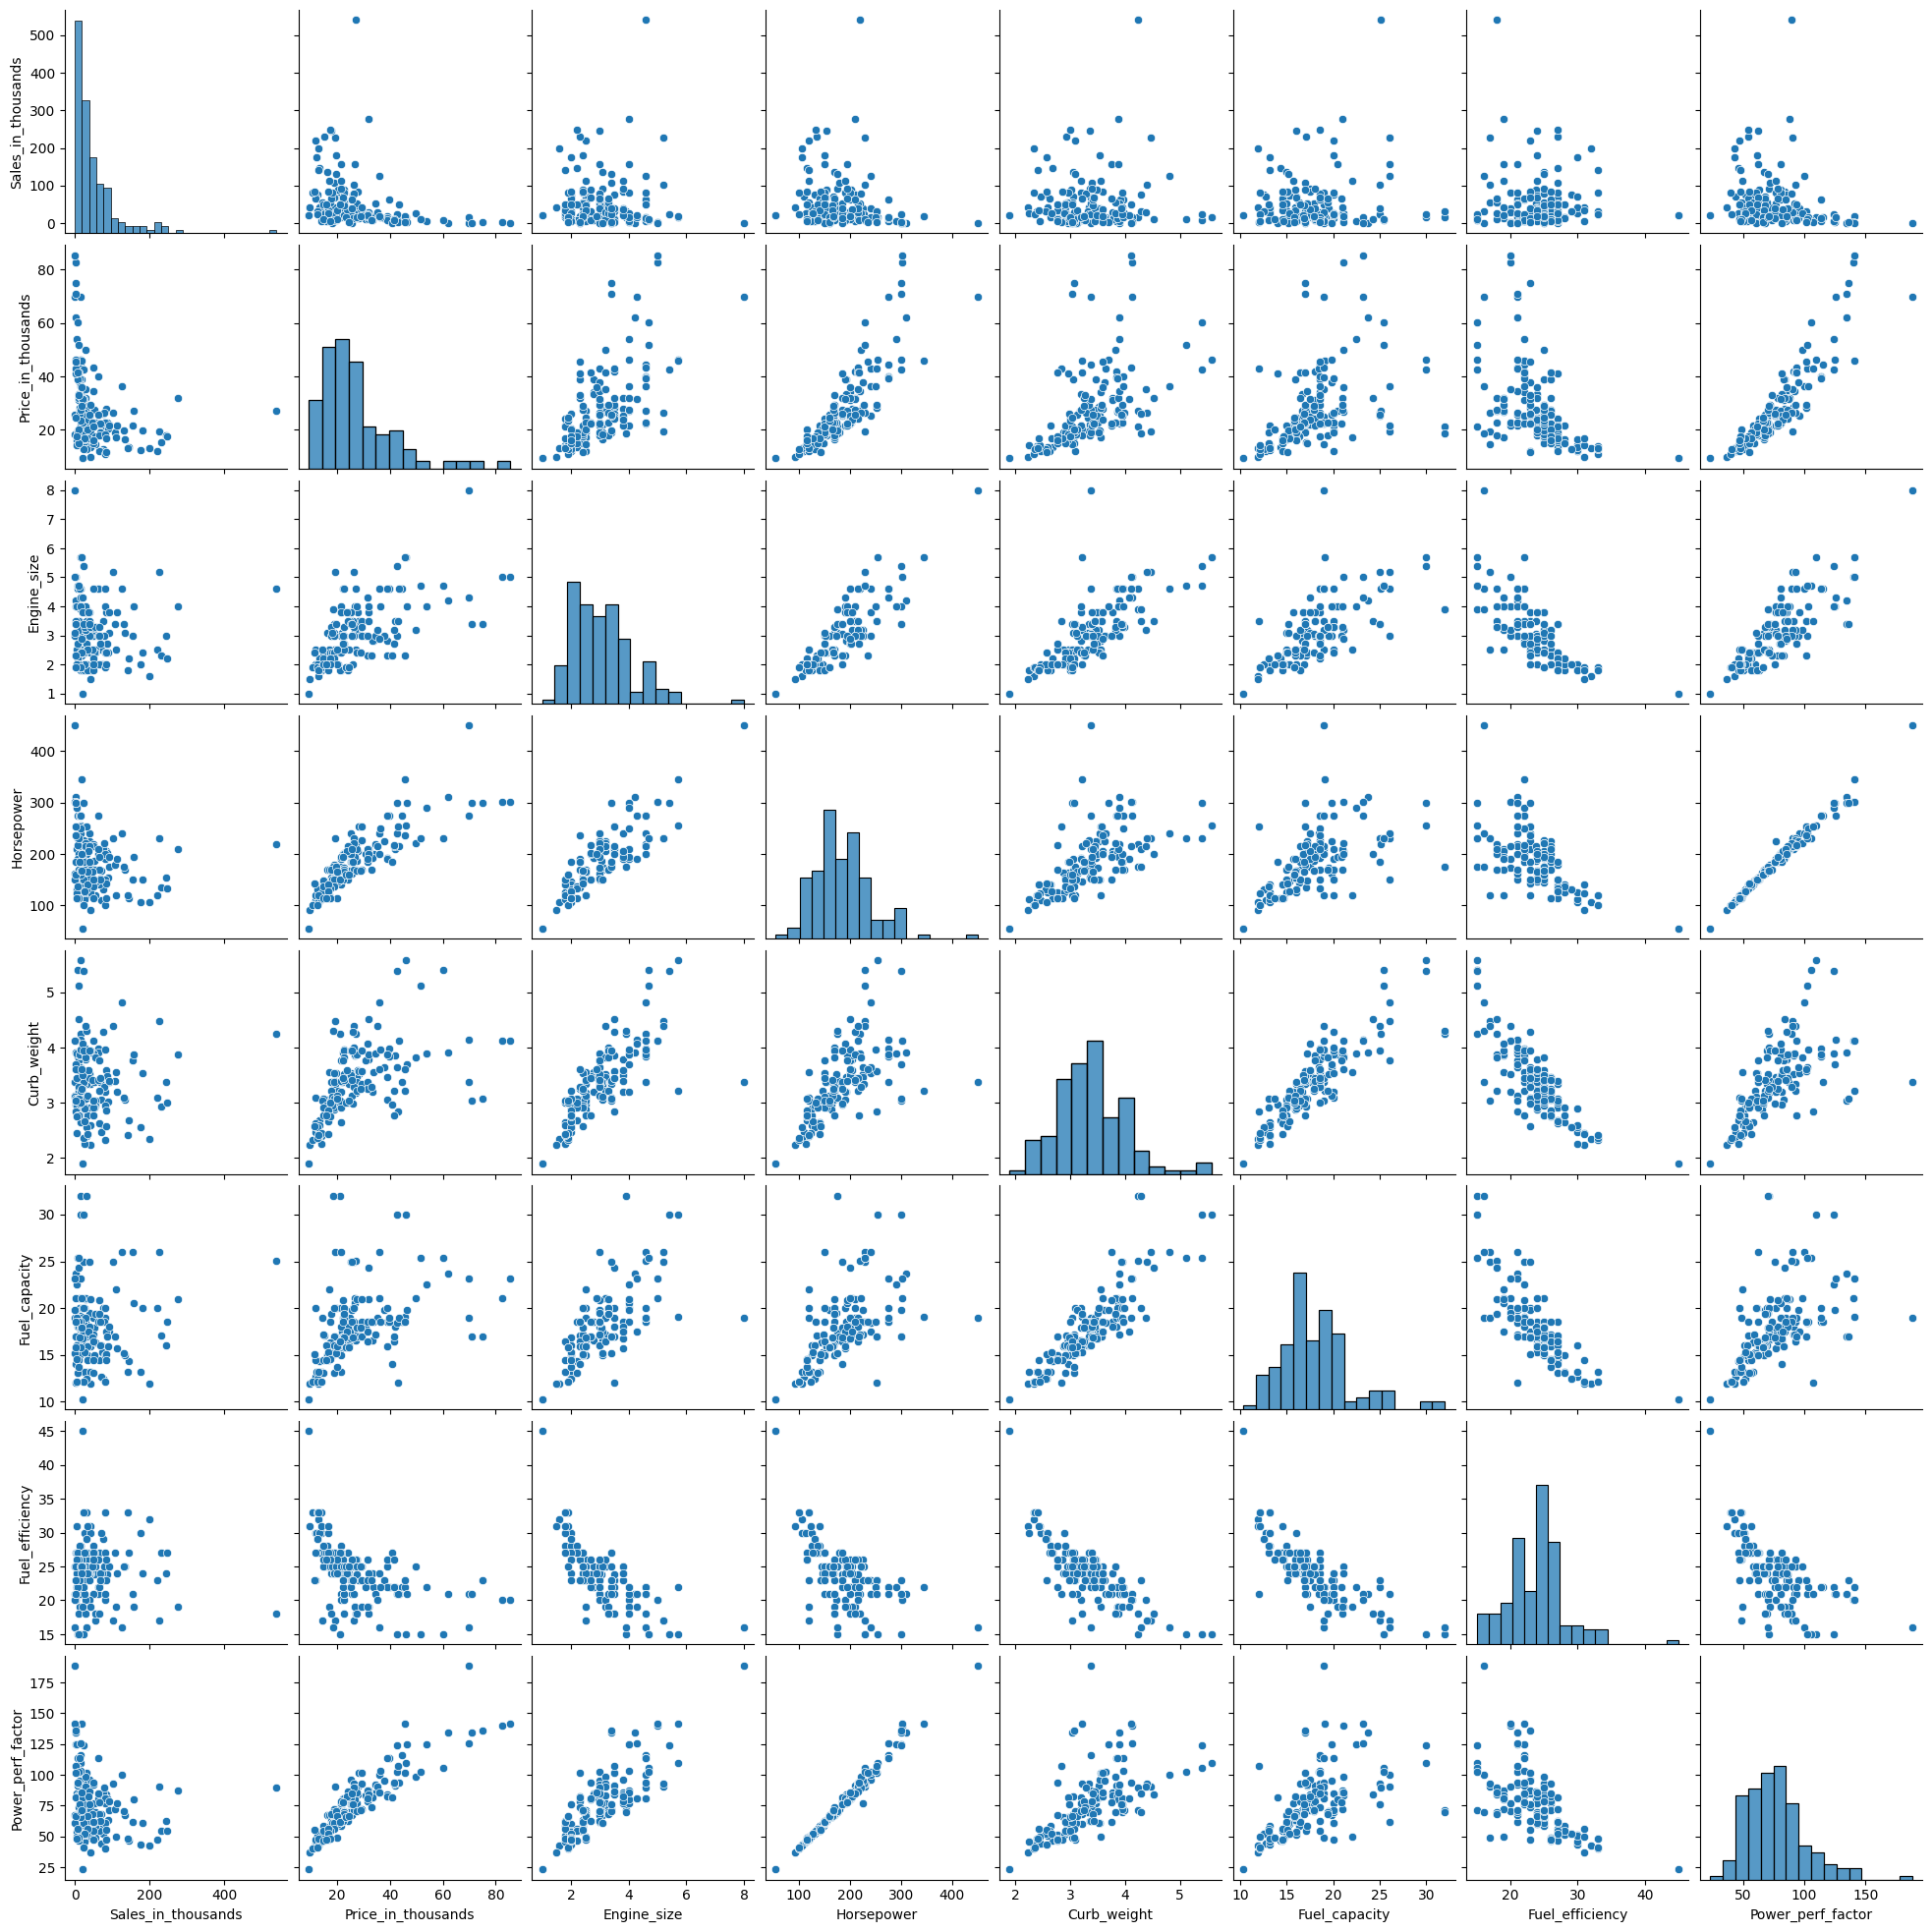

In [40]:
sns.pairplot(df_4)

Wybraliśmy diagram, który naszym zdaniem może najlepiej pokazać podział na grupy, na podstawie tego wykresu wstępnie zakładam $K=3$.

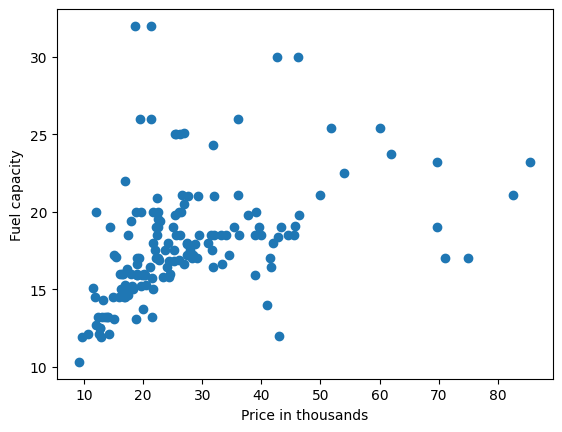

In [41]:
plt.scatter(x=df_3['Price_in_thousands'],y=df_3['Fuel_capacity'])
plt.xlabel('Price in thousands')
plt.ylabel('Fuel capacity')
plt.show()

W następnym kroku sprawdzimy podział na clustry za pomocą metody łokcia.

Zaczniemy od zestandaryzowania danych, żeby nie zakłamywały wykresu.

In [42]:
dataStandarized = (df_4-df_4.mean())/df_4.std()

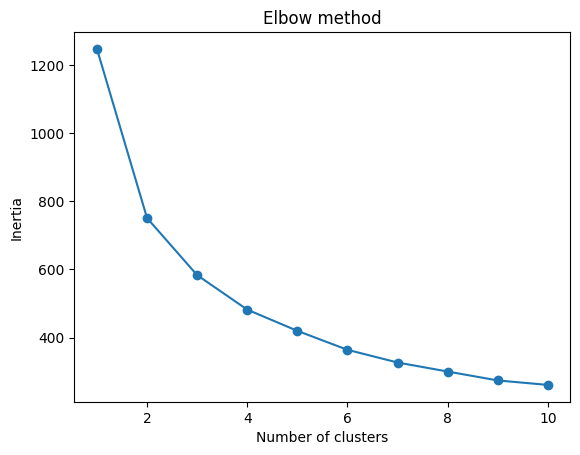

In [43]:
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(dataStandarized)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Jak widzimy, metoda łokcia potwierdziła nasz wcześniejszy podział na 3 klastry. Na wykresie poniżej możemy zobaczyć różnice rozmieszczenia pomiędzy poszczególnymi kolorami.

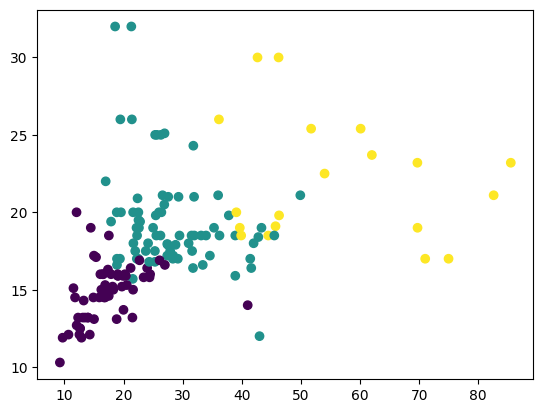

In [44]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(dataStandarized)

plt.scatter(df_3['Price_in_thousands'], df_3['Fuel_capacity'], c=kmeans.labels_)
plt.show()

### Grupowanie hierarchiczne

In [45]:
dfH1 = df.drop(columns=['Width','Length','Wheelbase','Latest_Launch','Vehicle_type','__year_resale_value'])
dfH1 = dfH1.set_index(['Manufacturer','Model'])
dfH1 = dfH1.fillna(dfH1.mean())
dfH1.info()
dfH1.describe()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 157 entries, ('Acura', 'Integra') to ('Volvo', 'S80')
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sales_in_thousands  157 non-null    float64
 1   Price_in_thousands  157 non-null    float64
 2   Engine_size         157 non-null    float64
 3   Horsepower          157 non-null    float64
 4   Curb_weight         157 non-null    float64
 5   Fuel_capacity       157 non-null    float64
 6   Fuel_efficiency     157 non-null    float64
 7   Power_perf_factor   157 non-null    float64
dtypes: float64(8)
memory usage: 17.0+ KB


,Sales_in_thousands,Price_in_thousands,Engine_size,Horsepower,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
count,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000
mean,52.998076,27.390755,3.060897,185.948718,3.378026,17.951923,23.844156,77.043591
std,68.029422,14.259359,1.041299,56.518297,0.626447,3.875440,4.241326,24.980973
min,0.110000,9.235000,1.000000,55.000000,1.895000,10.300000,15.000000,23.276272
25%,14.114000,18.145000,2.300000,150.000000,2.975000,15.800000,21.000000,60.727447
50%,29.450000,23.400000,3.000000,180.000000,3.368000,17.200000,24.000000,72.290355
75%,67.956000,31.930000,3.500000,215.000000,3.778000,19.500000,26.000000,89.401935
max,540.561000,85.500000,8.000000,450.000000,5.572000,32.000000,45.000000,188.144323


Standaryzujemy dane

In [46]:
dataHStandarized = (dfH1-dfH1.mean())/dfH1.std()

Dodajemy macierz odległości

In [79]:
distanceMatrix = pd.DataFrame(pairwise_distances(dataHStandarized))
distanceMatrix.head()

,0,1,2,3,4,5,6,7,8,9,...,147,148,149,150,151,152,153,154,155,156
0,0.000000,3.114045,2.802378,3.912806,1.078253,3.155496,6.779061,1.698774,2.419846,2.913658,...,1.206765,1.062330,0.949452,1.088914,1.236663,1.298826,1.948484,2.013929,3.823104,3.452798
1,3.114045,0.000000,0.730163,1.446897,2.450215,1.130676,4.016371,1.585941,1.128035,1.148195,...,2.470070,3.147291,3.305579,3.313796,2.225322,2.221310,1.643437,1.602621,1.738580,1.331988
2,2.802378,0.730163,0.000000,1.685090,2.150809,1.293538,4.371202,1.304293,1.060453,1.169511,...,2.234425,2.804214,2.949049,3.031135,1.976506,1.944338,1.391488,1.369985,2.011679,1.425535
3,3.912806,1.446897,1.685090,0.000000,3.184253,1.062294,3.284281,2.319290,1.578179,1.255186,...,3.307979,3.716240,3.943885,4.050343,2.925122,2.855089,2.225305,2.142295,1.415474,1.276875
4,1.078253,2.450215,2.150809,3.184253,0.000000,2.333470,6.034987,0.936295,1.775375,2.099130,...,0.499014,1.179146,1.200238,1.317878,0.555836,0.613327,1.041026,1.098746,3.067713,2.525707


Na podstawie klastrów przypisujemy odpowiednie rekordy do grup, następnie wyświetlimy spis producentów wraz z liczebnością ich aut w poszczególnych grupach

In [48]:
x = AgglomerativeClustering(n_clusters=4, linkage='ward')
y = x.fit_predict(dataHStandarized)
from scipy.cluster.hierarchy import linkage
groupsH = pd.Series(data=y, index=dataHStandarized.index)
print(groupsH)

Manufacturer  Model         
Acura         Integra           0
              TL                2
              CL                2
              RL                2
Audi          A4                0
              A6                2
              A8                3
BMW           323i              0
              328i              0
              528i              2
Buick         Century           0
              Regal             2
              Park Avenue       2
              LeSabre           0
Cadillac      DeVille           3
              Seville           3
              Eldorado          3
              Catera            2
              Escalade          1
Chevrolet     Cavalier          0
              Malibu            0
              Lumina            0
              Monte Carlo       0
              Camaro            2
              Corvette          3
              Prizm             0
              Metro             0
              Impala            0
Chrysler      Sebri

In [49]:
labels_df = groupsH.reset_index()
pd.crosstab(index=labels_df['Manufacturer'], columns=labels_df[0])

,0,1,2,3
Manufacturer,,,,
Acura,1,0,3,0
Audi,1,0,1,1
BMW,2,0,1,0
Buick,2,0,2,0
Cadillac,0,1,1,3
Chevrolet,7,0,1,1
Chrysler,3,0,4,0
Dodge,5,4,1,1
Ford,7,3,1,0


Jak widzimy duża część marek uchodzących za luksusowe ma samochody w 3 i 4 grupie (oznaczone poprzez indeksy 2 i 3)

Sprawdźmy cechy wszystkich grup

In [50]:
H0 = groupsH.loc[groupsH==0].index
dfH1.loc[H0].describe()

,Sales_in_thousands,Price_in_thousands,Engine_size,Horsepower,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,62.993778,18.684123,2.387654,145.641975,2.967136,15.875309,26.135802,59.342565
std,60.411271,5.193906,0.578874,27.689487,0.370878,2.571601,3.904334,11.506606
min,0.110000,9.235000,1.000000,55.000000,1.895000,10.300000,17.000000,23.276272
25%,19.747000,14.999000,2.000000,125.000000,2.762000,14.500000,24.000000,50.241978
50%,42.593000,18.270000,2.400000,150.000000,2.998000,15.900000,25.000000,60.861612
75%,83.257000,21.560000,2.500000,168.000000,3.217000,17.000000,27.000000,67.765908
max,247.994000,33.400000,4.000000,205.000000,3.761000,26.000000,45.000000,84.254526


In [51]:
manufacturerH0 = H0.groupby(['Manufacturer'])
manufacturerH0

{'Manufacturer': [('Acura', 'Integra')]}

In [52]:
H1 = groupsH.loc[groupsH==1].index
dfH1.loc[H1].describe()

,Sales_in_thousands,Price_in_thousands,Engine_size,Horsepower,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,125.046000,34.670727,4.718182,226.818182,4.710273,27.081818,16.181818,94.828389
std,166.281354,13.940572,0.614521,34.732746,0.576158,3.444653,1.401298,15.971891
min,9.126000,18.575000,3.900000,175.000000,3.876000,21.000000,15.000000,70.078322
25%,15.776000,23.812500,4.300000,215.000000,4.271500,25.250000,15.000000,88.518715
50%,31.038000,31.930000,4.700000,230.000000,4.470000,26.000000,16.000000,92.854125
75%,176.199500,44.442500,5.200000,235.000000,5.254000,30.000000,17.000000,104.144721
max,540.561000,60.105000,5.700000,300.000000,5.572000,32.000000,19.000000,123.972047


In [53]:
H2 = groupsH.loc[groupsH==2].index
dfH1.loc[H2].describe()

,Sales_in_thousands,Price_in_thousands,Engine_size,Horsepower,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,33.477260,30.893650,3.317218,207.558974,3.652301,18.691038,22.630649,85.913895
std,28.424598,7.414678,0.540075,20.527003,0.356460,2.343840,2.366073,8.725197
min,1.526000,22.195000,2.300000,170.000000,2.778000,12.000000,18.000000,69.671461
25%,13.625000,25.318750,3.000000,196.250000,3.458750,17.200000,21.000000,80.548179
50%,26.855000,28.370000,3.250000,205.000000,3.600500,18.500000,23.000000,84.697942
75%,41.823500,35.825000,3.500000,219.250000,3.895000,19.950000,24.750000,91.805296
max,157.040000,49.900000,4.600000,253.000000,4.520000,25.000000,27.000000,106.984456


In [54]:
H3 = groupsH.loc[groupsH==3].index
dfH1.loc[H3].describe()

,Sales_in_thousands,Price_in_thousands,Engine_size,Horsepower,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,11.255533,57.391600,4.626667,301.600000,3.705602,20.006667,21.133333,130.019265
std,15.899493,17.084781,1.111284,46.536929,0.387327,2.223725,1.641718,19.980325
min,0.916000,36.229000,3.400000,250.000000,3.032000,17.000000,16.000000,103.441693
25%,1.623000,42.185000,4.000000,275.000000,3.376513,18.500000,21.000000,114.737978
50%,6.375000,54.005000,4.600000,300.000000,3.868000,19.100000,22.000000,125.273876
75%,15.316500,70.372500,4.800000,302.000000,3.972500,21.800000,22.000000,137.948502
max,63.729000,85.500000,8.000000,450.000000,4.133000,23.700000,23.000000,188.144323


Następnie przechodzimy do porównania grup między sobą

In [55]:
def describe_clusters(labels: pd.Series, data: pd.DataFrame) -> pd.DataFrame:
    """ Zwraca DataFrame ze statystykami dla każdego klastra """
    df = data.copy()
    n_clusters = len(labels.unique())
    # średnie dla każdego klastra jako kolumny, nazwy zmiennych jako index
    stats = pd.concat(
        [
            df.loc[labels[labels == x].index].describe(
            ).loc['mean'].to_frame().rename(columns={'mean': f'cluster_{x+1}'})
            for x in range(n_clusters)
        ], axis=1)
    # kolumna ze średnią dla każdej zmiennej
    stats['mean'] = stats.apply(np.mean, axis=1)
    return stats.round(2)
describe_clusters(groupsH,dfH1)

,cluster_1,cluster_2,cluster_3,cluster_4,mean
Sales_in_thousands,62.99,125.05,33.48,11.26,58.19
Price_in_thousands,18.68,34.67,30.89,57.39,35.41
Engine_size,2.39,4.72,3.32,4.63,3.76
Horsepower,145.64,226.82,207.56,301.60,220.40
Curb_weight,2.97,4.71,3.65,3.71,3.76
Fuel_capacity,15.88,27.08,18.69,20.01,20.41
Fuel_efficiency,26.14,16.18,22.63,21.13,21.52
Power_perf_factor,59.34,94.83,85.91,130.02,92.53


Jak widzimy **klaster nr 1** charakteryzuje się zdecydowanie najmniejszą pojemnością silnika jak i ilością koni mechanicznych czy ceną, masa kadłuba i mocą (power_perf_factor). Wynika z tego, że klaster pierwszy to zdecydowanie samochody najbardziej przystępne dla przeciętnego użytkownika, część z nich może być lekko usportowiona jednak są to wciąż typowe samochody miejskie. Widzimy tutaj przewagę takich marek jak Ford, Mitsubishi, Toyota, Volkswagen i Volvo.

**Klaster nr 2**charakteryzuje się największą sprzedażą liczoną w tysiącach dolarów mimo drugiego miejsca w cenach samochodów znajdujących się w nim. Samochody w tym kalstrze są też najcięższe i mają największą pojemność paliwa. Możemy zatem wysnuć wnioski, że samochody te są prawdopodobnie SUV'ami lub samochodami terenowymi, o najlepszym stosunku ceny do jakości i udogodnień dla kierowcy (jak na przykład duża pojemność bagażnika). Z tego powodu generują one najwięszą sprzedaż nominalną. Spośród naszej próby do kalstra numer dwa została przypisana mała część modeli, są to jednak modele cieszące się wysoką popularnością wśród klientów.

**Klaster nr 3** to samochody pośrednie, ich sprzedaż jest zdecydowanie niższa niż w klastrze 1 i 2. Cena tych samochodów jest niewiele mniejsza od średniej wszystkich kalstrów, podobnie sytuacja wygląda w przypadku pojemności silnika, wagi kokpitu oraz mocy samochodu. Można te samochody nazwać przeciętnymi w tym zestawieniu.

**Klaster nr 4** cechuje się zdecydowanie najwyższymi cenami i ilością konii mechanicznych oraz mocy, jednak ilość sprzedanych modeli jest tutaj niska. Do tej grupy zaliczamy samochody luksusowe, sportowe oraz supersamochody. Marki przodujące w tym zestawieniu to Porsche, Mercedes-B i Cadillac

Wizualne zobrazowanie podziału jest również widoczne na dedogramie. Z uwagi na małą (losową) próbkę może on wyglądać różnie zależnie od konkretnego przypadku.

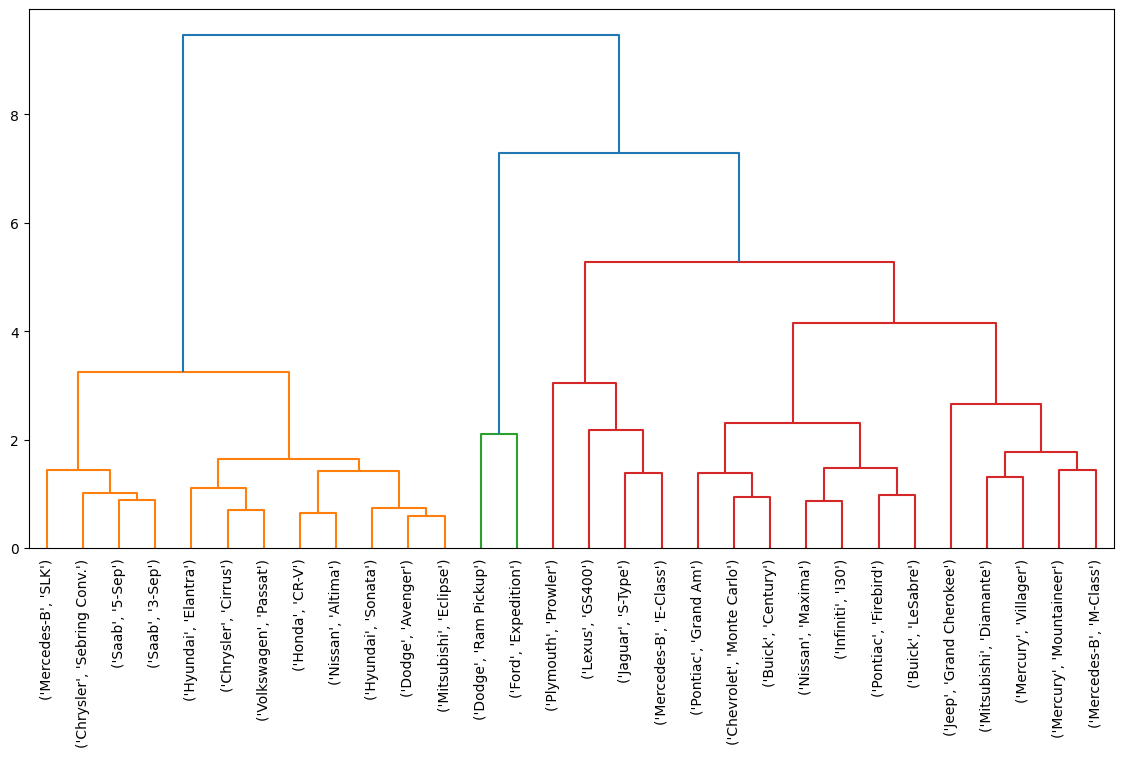

In [56]:
sample = dataHStandarized.sample(30)
Z = linkage(sample,method='ward')
plt.figure(figsize=(14,7))
scipy.cluster.hierarchy.dendrogram(Z, labels=sample.index, leaf_rotation=90);

### Skalowanie wielowymiarowe

In [57]:
model3d=MDS(n_components=8, 
          metric=True, 
          n_init=4, 
          max_iter=300, 
          verbose=0, 
          eps=0.001, 
          n_jobs=None, 
          random_state=42, 
          dissimilarity='euclidean')
model_trans = model3d.fit_transform(dataHStandarized)
print('stress dla 8 wymiarów:' + str(model3d.stress_))

stress dla 8 wymiarów:29.980268034966507


In [58]:
model3d1=MDS(n_components=7, 
          metric=True, 
          n_init=4, 
          max_iter=300, 
          verbose=0, 
          eps=0.001, 
          n_jobs=None, 
          random_state=42, 
          dissimilarity='euclidean')
model_trans = model3d1.fit_transform(dataHStandarized)

print('stress dla 7 wymiarów:' + str(model3d1.stress_))

stress dla 7 wymiarów:27.703243188125583


In [59]:
model3d2=MDS(n_components=6, 
          metric=True, 
          n_init=4, 
          max_iter=300, 
          verbose=0, 
          eps=0.001, 
          n_jobs=None, 
          random_state=42, 
          dissimilarity='euclidean')
model_trans = model3d2.fit_transform(dataHStandarized)

print('stress dla 6 wymiarów:' + str(model3d2.stress_))

stress dla 6 wymiarów:40.746730954695735


In [60]:
model3d3=MDS(n_components=5, 
          metric=True, 
          n_init=4, 
          max_iter=300, 
          verbose=0, 
          eps=0.001, 
          n_jobs=None, 
          random_state=42, 
          dissimilarity='euclidean')
model_trans = model3d3.fit_transform(dataHStandarized)
print('stress dla 5 wymiarów:' + str(model3d3.stress_))

stress dla 5 wymiarów:74.05683832466546


Jak widzimy parametr stress zwiększa się wraz ze zmniejszeniem ilości wymiarów. Chcemy by ten parametr był jak najmniejszy, jednak nie ma sensu by dane opisywane przez 8 zmiennych były przedstawiane na modelu 8 wymiarowym, z uwagi na to wybraliśmy przeskalowanie do 6 wymiarów.

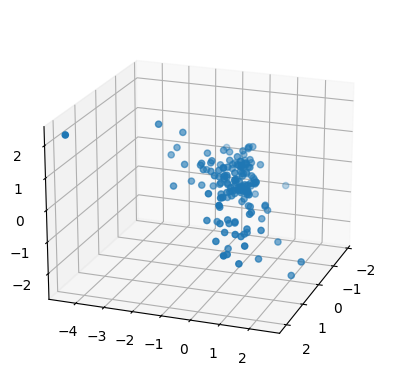

In [61]:
model3d4=MDS(n_components=6, 
          metric=True, 
          n_init=4, 
          max_iter=300, 
          verbose=0, 
          eps=0.001, 
          n_jobs=None, 
          random_state=42, 
          dissimilarity='euclidean')
model_trans = model3d4.fit_transform(dataHStandarized)
fig = plt.figure()
ax1 = fig.add_subplot(projection='3d')
ax1.scatter(model_trans[:,0],model_trans[:,1],model_trans[:,2], marker='o')
ax1.view_init(20, 20)
